# **Jour 45 : Winequality-red**

Cette base de données contient des informations sur **1596 échantillons de vins rouges portugais (Vinho Verde)**. Elle associe des mesures physico-chimiques (analysées en laboratoire) à des évaluations sensorielles (notes de qualité attribuées par des experts).

L'objectif principal est de prédire la **qualité du vin** (notée de **0** à **10**) en fonction de ses propriétés chimiques.

$\bigoplus$ **Signification des variables**

+  fixed acidity :	Acides fixes (acide tartrique, malique)
+  volatile acidity :	Acide acétique (trop élevé = goût de vinaigre)
+  citric acid :	Acidité citrique (fraîcheur et équilibre)
+  residual sugar :	Sucre restant après fermentation (en g/L)
+  chlorides :	Teneur en sel (goût salé/métallique)
+  free sulfur dioxide :	SO₂ libre (antioxydant et conservateur)
+  total sulfur dioxide :	SO₂ total (libre + lié)	
+  density :	Densité (liée à l'alcool et au sucre)
+  pH : 	Niveau d'acidité (échelle 0-14)	
+  sulphates :	Sulfate de potassium (agent conservateur)
+  alcohol :	Degré d'alcool (% en volume)
+  quality :	Note sensorielle (experts)	0 (très mauvais) → 10 (excellent)

## 0. Chargement des librairies

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import plotly.express as px
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan

## 1. Chargement de la base de données

In [92]:
data = pd.read_csv("../data/winequality-red.csv")


In [93]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. Valeurs manquantes et Statistiques Descriptives

### 2.1. Vérification des valeurs manquantes

In [94]:
print(data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Aucune valeur manquante dans la base.

### 2.2. Statistiques Descriptives

In [95]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1596.0,8.314160,1.732203,4.60000,7.1000,7.900000,9.200000,15.60000
volatile acidity,1596.0,0.527954,0.179176,0.12000,0.3900,0.520000,0.640000,1.58000
citric acid,1596.0,0.270276,0.193894,0.00000,0.0900,0.260000,0.420000,0.79000
residual sugar,1596.0,2.535558,1.405515,0.90000,1.9000,2.200000,2.600000,15.50000
chlorides,1596.0,0.087120,0.045251,0.01200,0.0700,0.079000,0.090000,0.61100
free sulfur dioxide,1596.0,15.858396,10.460554,1.00000,7.0000,14.000000,21.000000,72.00000
total sulfur dioxide,1596.0,46.382206,32.839138,6.00000,22.0000,38.000000,62.000000,289.00000
density,1596.0,0.996744,0.001888,0.99007,0.9956,0.996745,0.997833,1.00369
pH,1596.0,3.311917,0.153346,2.86000,3.2100,3.310000,3.400000,4.01000
sulphates,1596.0,0.656385,0.163057,0.33000,0.5500,0.620000,0.730000,1.98000


Sur les 1596 échantillons de vin rouges, si les bouteilles devraient avoir la même qualité alors chaque bouteille serait notée **5,63** avec un écart de **±0,80 unité** par rapport à cette dernière. 

## 3. Explorations Visuelles

### 3.1. Distribution des Notes

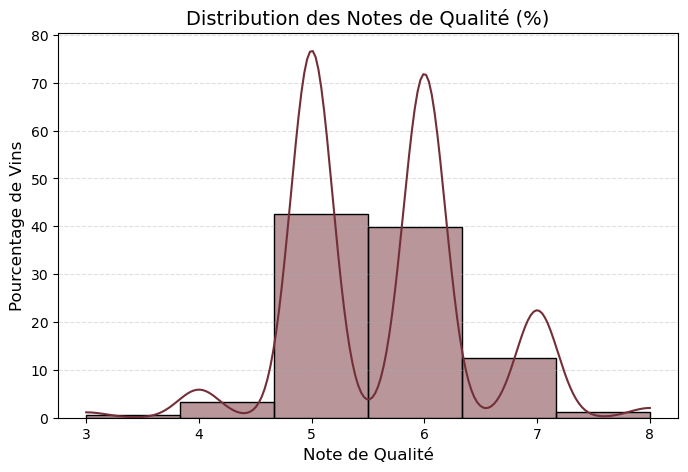

In [96]:
plt.figure(figsize=(8, 5))
sns.histplot(data['quality'], bins=6, kde=True, color='#722F37', stat='percent')

plt.title("Distribution des Notes de Qualité (%)", fontsize=14)
plt.xlabel("Note de Qualité", fontsize=12)
plt.ylabel("Pourcentage de Vins", fontsize=12)
plt.xticks(range(3, 9))
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

Un grand nombre des bouteilles de vin ont leurs notes comprises entre **5** et **6**.

### 3.2. Matrice de corrélation linéaire de Pearson

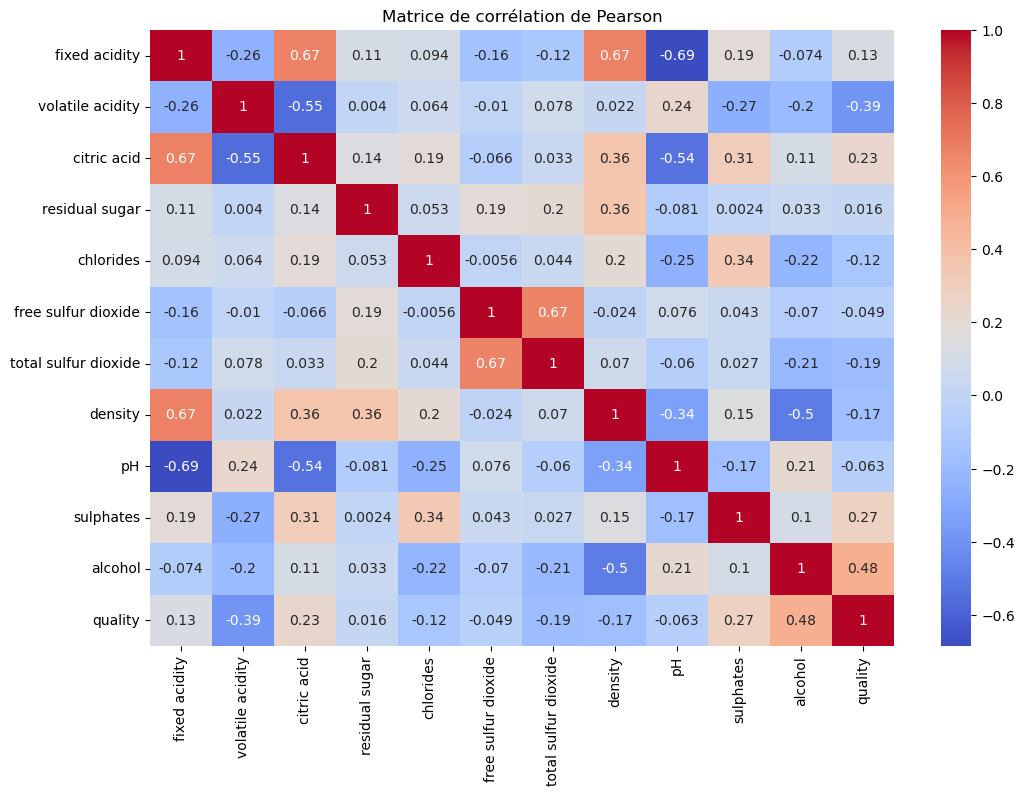

In [97]:
correlation_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Pour l'affichage des valeurs 
    cmap='coolwarm',  # Palette de couleurs
)

plt.title("Matrice de corrélation de Pearson")
plt.show()


## 4. Modélisation

### 4.1. Préparation des données et régression linéaire

In [98]:
# Variables explicatives et cible
X = data.drop('quality', axis=1)
y = data['quality']

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)


### 4.2. Evaluation du modèle

In [99]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("R²:", r2_score(y_test, y_pred))
print(f"RMSE : {rmse:.2f}")


R²: 0.3382412510368389
RMSE : 0.66


Nous retrouvant dans un cas de régression prédictive, on peut juste exploiter le **RMSE** pour évaluer notre modèle.
Notre **RMSE** de **0.663** signifie qu'en moyenne, les prédictions de notre modèle s'écartent des valeurs réelles d'environ **0.663 unités**. Le modèle a alors une bonne capacité prédictive compte tenu de la plage de valeurs de notre variable cible.

## 5. Analyse des Résidus

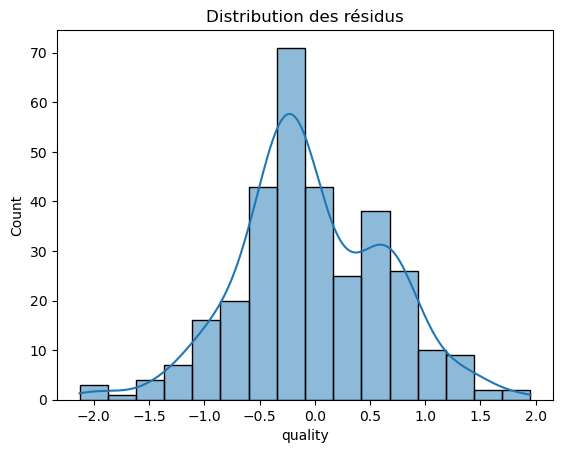

Statistique de Shapiro-Wilk: ShapiroResult(statistic=0.9879327168454586, pvalue=0.00918102715851562)


In [100]:
residuals = y_test - y_pred

# Histogramme
sns.histplot(residuals, kde=True)
plt.title('Distribution des résidus')
plt.show()

# Test de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals)
print("Statistique de Shapiro-Wilk:", shapiro_test)


Visuellement, la distribution des résidus semble assez symétrique et en forme de cloche. Toutefois, il y a quelques légères asymétries et irrégularités sur les côtés (queues un peu lourdes). Bien que le test rejette  la normalité (**pvalue>0,05**), la forme globale reste proche de la normale. Pour notre cas de régression prédictives, cette légère non-normalité n’est pas forcément bloquante.

In [101]:
# Test d'hétéroscédasticité
X_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_sm).fit()
test_bp = sms.het_breuschpagan(model_sm.resid, X_sm)

print("Breusch-Pagan p-value:", test_bp[1])


Breusch-Pagan p-value: 1.1119840366877727e-07


Ici, la p-value est largement inférieure à 0.05, donc on rejette l’hypothèse nulle d’homoscédasticité.
Cela signifie que les erreurs de notre modèle n’ont pas une variance constante : il y a donc présence d’hétéroscédasticité. Pour ce fait nous passerons de notre modèle à un modèle plus robuste aux hétéroscédasticités (comme la régression avec erreurs standards robustes).





In [102]:


X_sm = sm.add_constant(X_train)
model_robust = sm.OLS(y_train, X_sm).fit(cov_type='HC3')  # ou 'HC0', 'HC1', 'HC2'

print(model_robust.summary())


                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     69.74
Date:                Mon, 05 May 2025   Prob (F-statistic):          6.39e-122
Time:                        13:51:07   Log-Likelihood:                -1235.1
No. Observations:                1276   AIC:                             2494.
Df Residuals:                    1264   BIC:                             2556.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   37.9363 

L’hétéroscédasticité dans les résidus n'est pas corrigée mais cela permet d'ajuster les erreurs standards pour qu’elles restent fiables même en sa présence.

## 6. Validation du modèle 

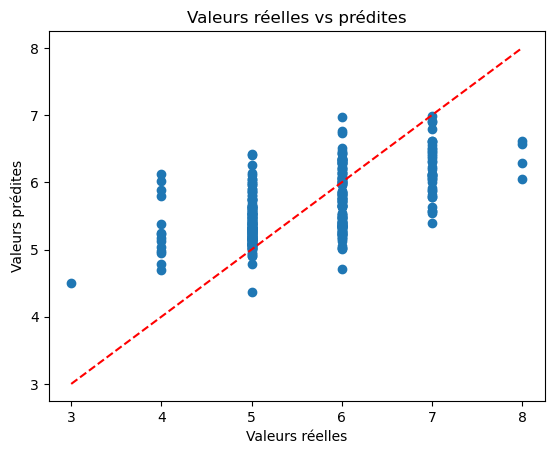

In [103]:
plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs réelles vs prédites')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()


La majorité des points sont proches mais pas exactement sur la ligne rouge. On observe une tendance générale correcte (plus la qualité réelle est élevée, plus la prédiction l’est aussi), mais avec une variabilité importante. Le modèle capte bien la tendance générale de la qualité.


## 6. Prédiction

In [104]:
new_data = X_test.iloc[:5]
new_predictions = model.predict(new_data)
print("Prédictions :", new_predictions)


Prédictions : [5.75640581 5.79909738 5.27967879 6.05304862 5.48129959]


Ces résultats suggèrent que, pour les cinq observations analysées, les vins sont globalement considérés comme étant de qualité moyenne, avec quelques variations autour de la moyenne. On dira que ces  prédictions indiquent que les vins en question sont dans la catégorie des vins "acceptables" ou "moyennement bons".